In [46]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import pydotplus 
from IPython.display import Image
import statistics
import numpy as np

In [1]:
from google.colab import drive

drive.mount('/content/drive')

DATA_PATH = '/content/drive/MyDrive/'

Mounted at /content/drive


In [7]:
DATA_PATH = 'G:/Shared drives/DM_tweets/data/'

In [30]:
def get_metrics(target, pred, target_labels, verbose=True):
  print('Accuracy', metrics.accuracy_score(target, pred))
  if verbose:
    print('Precision set ', metrics.precision_score(target, pred, average='weighted'))
    print('Recall set ', metrics.recall_score(target, pred, average='weighted'))
    print('F1 score set ', metrics.f1_score(target, pred, average='weighted'))
    print('Support set ', metrics.precision_recall_fscore_support(target, pred))

  print(metrics.classification_report(target, pred, target_names = target_labels))

In [31]:
def confusion_matrix(target, pred):
  cm = metrics.confusion_matrix(target, pred)
  disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
  disp.plot()
  plt.show() 

In [42]:
def cross_validation(model, tr, target):
  cv_scores = cross_validate(model, tr, target, cv=5, return_train_score = True, scoring=['accuracy','recall','f1'])

  for k in cv_scores.keys():
      cv_scores[k] = statistics.mean(cv_scores[k])
  return cv_scores
#  print('Cross Validation Validation score ', statistics.mean(cv_scores['test_score']))
#  print('Cross Validation Train score ', statistics.mean(cv_scores['train_score']))

In [11]:
df_indicators = pd.read_csv(DATA_PATH + 'indicators_clean.csv', sep='#')
#df_tweets_ind = pd.read_csv(DATA_PATH+'tweets_with_indicators.csv', sep='#')
df_users = pd.read_csv(DATA_PATH + 'users_clean.csv', sep='#')

In [12]:
df_users.id = df_users.id.astype(str)
df_merge = df_users.merge(df_indicators, left_on='id', right_on='user_id', how='left')

In [13]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11508 entries, 0 to 11507
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   11508 non-null  object 
 1   name                 11507 non-null  object 
 2   lang                 11508 non-null  object 
 3   bot                  11508 non-null  int64  
 4   created_at           11508 non-null  object 
 5   statuses_count       11508 non-null  float64
 6   created_at_conv      11508 non-null  int64  
 7   user_id              11504 non-null  object 
 8   2012_tweets          11504 non-null  float64
 9   2013_tweets          11504 non-null  float64
 10  2014_tweets          11504 non-null  float64
 11  2015_tweets          11504 non-null  float64
 12  2016_tweets          11504 non-null  float64
 13  2017_tweets          11504 non-null  float64
 14  2018_tweets          11504 non-null  float64
 15  2019_tweets          11504 non-null 

In [14]:
# Drop variables which aren't useful for classification purposes
df_merge.drop(columns=['id', 'name', 'created_at', 'user_id'], inplace=True)
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11508 entries, 0 to 11507
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   lang                 11508 non-null  object 
 1   bot                  11508 non-null  int64  
 2   statuses_count       11508 non-null  float64
 3   created_at_conv      11508 non-null  int64  
 4   2012_tweets          11504 non-null  float64
 5   2013_tweets          11504 non-null  float64
 6   2014_tweets          11504 non-null  float64
 7   2015_tweets          11504 non-null  float64
 8   2016_tweets          11504 non-null  float64
 9   2017_tweets          11504 non-null  float64
 10  2018_tweets          11504 non-null  float64
 11  2019_tweets          11504 non-null  float64
 12  2020_tweets          11504 non-null  float64
 13  mean_length          11504 non-null  float64
 14  retweets_count_mean  11504 non-null  float64
 15  retweets_count_std   11394 non-null 

In [15]:
def discretize_column(df, column_name):
    #get the unique variable's values
    values = df[column_name].unique()

    d = dict( (el, i) for i, el in enumerate(values) )

    df[column_name + '_discr'] = df[column_name].apply(lambda x: d[x])

In [16]:
# Convert lang column to numbers (e.g. en = 0, it = 1, etc.)
discretize_column(df_merge, 'lang')

# Drop original lang column
df_merge.drop(columns=['lang'], inplace=True)
df_merge

,bot,statuses_count,created_at_conv,2012_tweets,2013_tweets,2014_tweets,2015_tweets,2016_tweets,2017_tweets,2018_tweets,...,retweets_count_mean,retweets_count_std,reply_count_mean,favorite_count_mean,num_hashtags_mean,num_urls_mean,num_mentions_mean,created_at_mean,max_daily_tweets,lang_discr
0,1,76.0,1550858442000000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.558662e+18,3.468087e+15,0.000000,0.0,0.042017,0.109244,0.000000,0.294118,17.0,0
1,0,54.0,1551150152000000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.558870e+18,3.358891e+15,0.028302,0.0,0.056604,0.028302,0.000000,0.358491,18.0,0
2,1,3.0,1430377796000000000,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,1.465603e+18,3.711812e+13,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,2.0,0
3,1,50.0,1484707758000000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.568332e+18,4.654915e+15,0.000000,0.0,0.000000,0.084318,0.023641,0.007092,130.0,1
4,0,7085.0,1560886221000000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.583181e+18,3.029799e+15,0.000000,0.0,0.000000,0.132962,0.000928,0.528139,47.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11503,0,1126.0,1575033362000000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.582615e+18,2.670263e+15,0.000000,0.0,0.000000,0.216867,0.027108,0.745984,52.0,0
11504,0,3024.0,1524798118000000000,0.0,0.0,0.0,0.0,0.0,0.0,547.0,...,1.553837e+18,1.947614e+16,0.000000,0.0,0.000000,0.129989,0.100324,0.544229,83.0,0
11505,0,6.0,1427648484000000000,0.0,0.0,0.0,1.0,2.0,3.0,0.0,...,1.482631e+18,3.028465e+16,0.000000,0.0,0.000000,0.333333,0.666667,0.333333,2.0,4
11506,1,42.0,1552445053000000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.559683e+18,3.093993e+15,0.000000,0.0,0.084211,0.010526,0.000000,0.400000,10.0,0


In [17]:
# Eliminate NaN values
df_merge = df_merge.fillna(value=0)

In [18]:
class_predict = df_merge.pop('bot')
tr, ts, tr_target, ts_target = train_test_split(df_merge, class_predict, stratify =class_predict, test_size=0.20)

In [19]:
print(f'Number of samples in Training set:', len(tr))
print(f'Number of samples in Test set:', len(ts))

Number of samples in Training set: 9206
Number of samples in Test set: 2302


# Decision Tree

In [145]:
d_tree = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=10, min_samples_split=5, min_samples_leaf=3)
# criterion{“gini”, “entropy”, “log_loss”}
# min_impurity_decrease
d_tree = d_tree.fit(tr, tr_target)

bot, non-bot 
oppure
non-bot, bot?

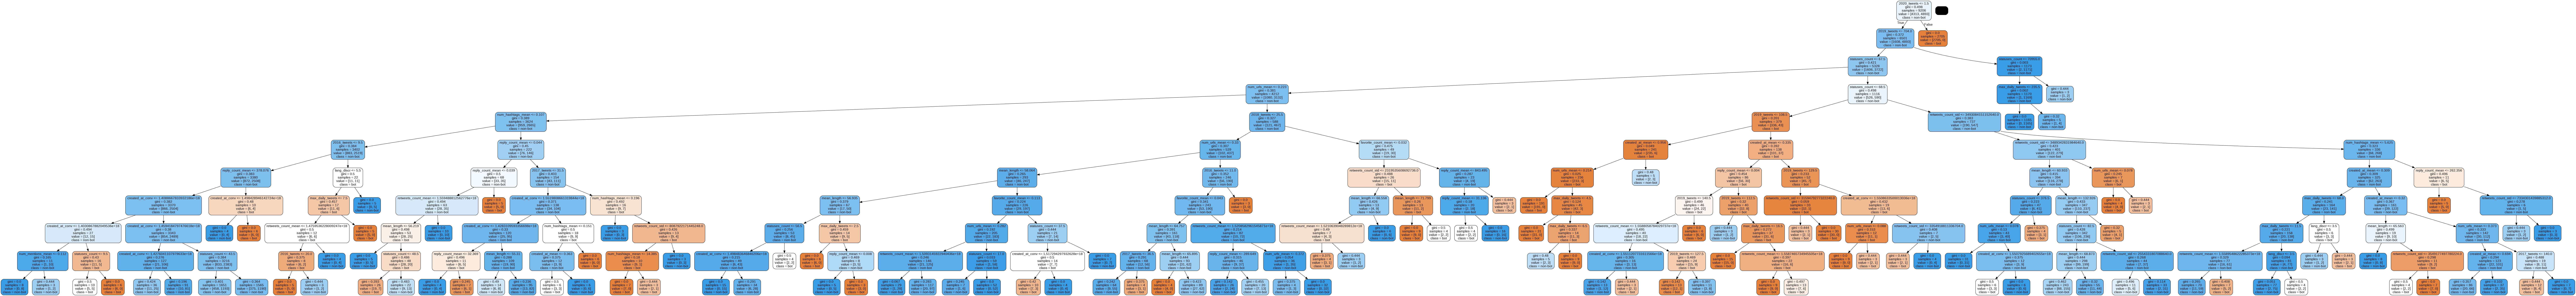

In [146]:
dot_data = export_graphviz(d_tree, out_file=None, feature_names=list(ts.columns), class_names=['bot', 'non-bot'], filled=True, rounded=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

Accuracy 0.8729089724092983
Precision set  0.8923622106970632
Recall set  0.8729089724092983
F1 score set  0.8702337688949778
Support set  (array([0.98249923, 0.81290973]), array([0.74194296, 0.98835071]), array([0.84544254, 0.89208633]), array([4313, 4893]))
              precision    recall  f1-score   support

         bot       0.98      0.74      0.85      4313
     non-bot       0.81      0.99      0.89      4893

    accuracy                           0.87      9206
   macro avg       0.90      0.87      0.87      9206
weighted avg       0.89      0.87      0.87      9206



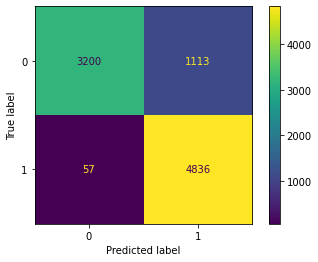

In [147]:
tr_pred = d_tree.predict(tr)
labels = ['bot', 'non-bot']
get_metrics(tr_target, tr_pred, labels)
confusion_matrix(tr_target, tr_pred)

In [148]:
cross_validation(d_tree, tr, tr_target)
ts_pred = d_tree.predict(ts)

Cross Validation Validation score  0.8402109390343373
Cross Validation Train score  0.8720942195809194


TODO: scatter plots

In [ ]:
# Example
plt.scatter(df_users[df_users['bot'] == 0]['created_at_conv'], 
            df_users[df_users['bot'] == 0]['lang'], color='g', marker='*', label='Non-bot user')
plt.scatter(df_users[df_users['bot'] == 1]['created_at_conv'], 
            df_users[df_users['bot'] == 1]['lang'], color='r', marker='2', label='Bot user')
plt.xlabel('created_at')
plt.ylabel('lang')
plt.legend()
plt.show()

# Naive Bayes

Accuracy 0.6658700847273518
Precision set  0.7161603721871819
Recall set  0.6658700847273518
F1 score set  0.6349452100612791
Support set  (array([0.81963824, 0.62494843]), array([0.36772548, 0.92867362]), array([0.50768246, 0.74712266]), array([4313, 4893]))
              precision    recall  f1-score   support

         bot       0.82      0.37      0.51      4313
     non-bot       0.62      0.93      0.75      4893

    accuracy                           0.67      9206
   macro avg       0.72      0.65      0.63      9206
weighted avg       0.72      0.67      0.63      9206



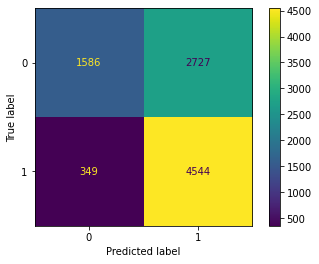

In [149]:
n_bayes = GaussianNB()
n_bayes.fit(tr, tr_target)
tr_pred = n_bayes.predict(tr)
labels = ['bot', 'non-bot']
get_metrics(tr_target, tr_pred, labels)
confusion_matrix(tr_target, tr_pred)

In [150]:
cross_validation(n_bayes, tr, tr_target)
ts_bayes = n_bayes.predict(ts)

Cross Validation Validation score  0.6657603589608395
Cross Validation Train score  0.6653813878861697


# Random Forest

In [27]:
r_forest = RandomForestClassifier(n_estimators=200, criterion='gini', min_samples_split=5, min_samples_leaf=4, bootstrap=True)
# criterion{“gini”, “entropy”, “log_loss”}
# max_features{“sqrt”, “log2”, None}, 
r_forest = r_forest.fit(tr, tr_target)

Accuracy 0.9035411688029545
Precision set  0.9176371021244443
Recall set  0.9035411688029545
F1 score set  0.902074379228182
Support set  (array([0.99709724, 0.8475959 ]), array([0.7964294 , 0.99795626]), array([0.88553751, 0.91665102]), array([4313, 4893], dtype=int64))
              precision    recall  f1-score   support

         bot       1.00      0.80      0.89      4313
     non-bot       0.85      1.00      0.92      4893

    accuracy                           0.90      9206
   macro avg       0.92      0.90      0.90      9206
weighted avg       0.92      0.90      0.90      9206



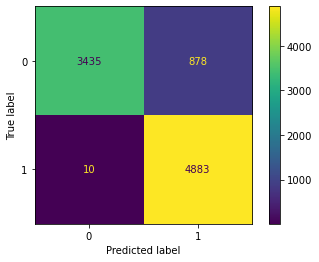

In [28]:
tr_pred = r_forest.predict(tr)
labels = ['bot', 'non-bot']
get_metrics(tr_target, tr_pred, labels)
confusion_matrix(tr_target, tr_pred)

In [37]:
cross_validation(r_forest, tr, tr_target)
ts_bayes = r_forest.predict(ts)

KeyError: 'test_score'

In [43]:
cross_validation(r_forest, tr, tr_target)

{'fit_time': 2.089498424530029,
 'score_time': 0.06875596046447754,
 'test_accuracy': 0.8554204773523335,
 'train_accuracy': 0.9073159160747152,
 'test_recall': 0.9881463702998134,
 'train_recall': 0.9986715533393242,
 'test_f1': 0.879039484037853,
 'train_f1': 0.919704385127099}

In [61]:
parameters = {
    "n_estimators": range(50,500,100),
    "criterion": ["gini","entropy","log_loss"]
}
'''
"max_depth": [None] + list(range(5,100,10)),
    #"min_samples_split": [2,4,8,16,32,64],
    "min_samples_split": [2,16,64],
    #"min_samples_leaf": [2,4,8,16,32,64,128],
    "min_samples_leaf": [2,16,64,128],
    "max_features":["auto","sqrt","log2",None],
    "max_leaf_nodes":[None] + list(range(1,10,2)),
    "min_impurity_decrease": 0.1 * np.array(range(1,5))
'''


'  \n"max_depth": [None] + list(range(5,100,10)),\n    #"min_samples_split": [2,4,8,16,32,64],\n    "min_samples_split": [2,16,64],\n    #"min_samples_leaf": [2,4,8,16,32,64,128],\n    "min_samples_leaf": [2,16,64,128],\n    "max_features":["auto","sqrt","log2",None],\n    "max_leaf_nodes":[None] + list(range(1,10,2)),\n    "min_impurity_decrease": 0.1 * np.array(range(1,5))\n'

In [62]:
dim = 1
for k in parameters.keys():
    dim *= len(parameters[k])
print(dim)

15


In [63]:
gs = GridSearchCV(r_forest,param_grid=parameters, scoring=['accuracy','recall','f1'], verbose=3,refit=False)

In [64]:
gs.fit(tr,tr_target)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV 1/5] END criterion=gini, n_estimators=50; accuracy: (test=0.853) f1: (test=0.877) recall: (test=0.985) total time=   0.6s
[CV 2/5] END criterion=gini, n_estimators=50; accuracy: (test=0.856) f1: (test=0.879) recall: (test=0.987) total time=   0.5s
[CV 3/5] END criterion=gini, n_estimators=50; accuracy: (test=0.851) f1: (test=0.876) recall: (test=0.987) total time=   0.6s
[CV 4/5] END criterion=gini, n_estimators=50; accuracy: (test=0.845) f1: (test=0.872) recall: (test=0.989) total time=   0.5s
[CV 5/5] END criterion=gini, n_estimators=50; accuracy: (test=0.862) f1: (test=0.883) recall: (test=0.982) total time=   0.5s
[CV 1/5] END criterion=gini, n_estimators=150; accuracy: (test=0.855) f1: (test=0.879) recall: (test=0.990) total time=   1.5s
[CV 2/5] END criterion=gini, n_estimators=150; accuracy: (test=0.852) f1: (test=0.876) recall: (test=0.985) total time=   1.5s
[CV 3/5] END criterion=gini, n_estimators=150; accuracy

C:\Users\al\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
25 fits failed out of a total of 75.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\al\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\al\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 450, in fit
    trees = Parallel(
  File "C:\Users\al\anaconda3\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\al\anaconda3\lib\site-packages\joblib\parallel.p

GridSearchCV(estimator=RandomForestClassifier(min_samples_leaf=4,
                                              min_samples_split=5,
                                              n_estimators=200),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'n_estimators': range(50, 500, 100)},
             refit=False, scoring=['accuracy', 'recall', 'f1'], verbose=3)

In [65]:
pd.DataFrame(gs.cv_results_).to_csv("random_forest_gs_results.csv")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_n_estimators,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,...,std_test_recall,rank_test_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1
0,0.608557,0.064217,0.026259,0.008374,gini,50,"{'criterion': 'gini', 'n_estimators': 50}",0.853420,0.856056,0.851168,...,0.002421,10,0.877161,0.879381,0.875793,0.871564,0.883165,0.877413,0.003843,10
1,1.539208,0.027788,0.051781,0.002160,gini,150,"{'criterion': 'gini', 'n_estimators': 150}",0.854506,0.851711,0.854427,...,0.004618,8,0.878513,0.875965,0.878513,0.874887,0.885095,0.878595,0.003547,7
2,2.552853,0.081574,0.081552,0.002973,gini,250,"{'criterion': 'gini', 'n_estimators': 250}",0.855049,0.852254,0.853884,...,0.004260,7,0.878802,0.876364,0.878446,0.872695,0.886427,0.878546,0.004498,8
3,3.694177,0.132688,0.116957,0.007010,gini,350,"{'criterion': 'gini', 'n_estimators': 350}",0.855592,0.853884,0.852797,...,0.003142,5,0.879420,0.877672,0.877320,0.873480,0.887045,0.878987,0.004471,6
4,4.539945,0.106185,0.147498,0.004690,gini,450,"{'criterion': 'gini', 'n_estimators': 450}",0.855049,0.852797,0.854970,...,0.004597,1,0.878912,0.876650,0.879349,0.875000,0.887149,0.879412,0.004176,4
5,0.747248,0.010979,0.020513,0.000602,entropy,50,"{'criterion': 'entropy', 'n_estimators': 50}",0.855049,0.848995,0.853341,...,0.006065,9,0.878802,0.873521,0.878049,0.874381,0.885291,0.878009,0.004170,9
6,2.154744,0.074342,0.050961,0.000738,entropy,150,"{'criterion': 'entropy', 'n_estimators': 150}",0.855049,0.853341,0.855513,...,0.004260,3,0.878912,0.877273,0.879638,0.874887,0.887760,0.879694,0.004351,1
7,5.432840,2.369643,0.115296,0.042988,entropy,250,"{'criterion': 'entropy', 'n_estimators': 250}",0.855592,0.852254,0.856056,...,0.004355,4,0.879310,0.876251,0.879819,0.875788,0.886228,0.879479,0.003734,3
8,9.816453,0.958650,0.249620,0.047486,entropy,350,"{'criterion': 'entropy', 'n_estimators': 350}",0.855592,0.853341,0.856056,...,0.005583,2,0.879420,0.876937,0.880145,0.875506,0.886123,0.879626,0.003653,2
9,12.076668,2.160699,0.281048,0.082666,entropy,450,"{'criterion': 'entropy', 'n_estimators': 450}",0.855592,0.852797,0.855513,...,0.005471,6,0.879420,0.876538,0.879638,0.874887,0.885095,0.879115,0.003482,5
